# Scalable Batch GP Classification in 1D (w/ SVGP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `VariationalStrategy` module while learning the inducing point locations.


**Note:** The performance of this notebook is substantially improved by using a GPU and casting your tensors with `.cuda()`. See our other GPU example notebooks for how to do this.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


In [2]:
train_x = torch.linspace(0, 1, 260).unsqueeze(-1)
train_y_cos = torch.cos(train_x * (2 * math.pi)).squeeze() + 0.1 * torch.randn(260)
train_y_sin = torch.sin(train_x * (2 * math.pi)).squeeze() + 0.1 * torch.randn(260)

# Make train_x (2 x 260 x 1) and train_y (2 x 260)
train_x = torch.cat([train_x, train_x], dim=1).transpose(-2, 1).unsqueeze(-1)
train_y = torch.cat([train_y_cos.unsqueeze(-1), train_y_sin.unsqueeze(-1)], dim=1).transpose(-2, -1)

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
class SVGPRegressionModel(AbstractVariationalGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2), batch_size=2)
        variational_strategy = VariationalStrategy(self,
                                                   inducing_points,
                                                   variational_distribution,
                                                   learn_inducing_locations=True)
        super(SVGPRegressionModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# We'll initialize the inducing points to evenly span the space of train_x
inducing_points = torch.linspace(0, 1, 25).unsqueeze(-1).repeat(2, 1, 1)
model = SVGPRegressionModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [4]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.size(-1), combine_terms=False)

def train():
    num_iter = 200
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        log_lik, kl_div, log_prior = mll(output, train_y)
        loss = -(log_lik - kl_div + log_prior)
        loss = loss.sum()
        loss.backward()
        if i % 50 == 0:
            print('Iter %d - Loss: %.3f [%.3f, %.3f, %.3f]' % (i + 1, loss.item(), log_lik.sum().item(), kl_div.sum().item(), log_prior.sum().item()))
        optimizer.step()
        
# Get clock time
with gpytorch.beta_features.diagonal_correction():
    %time train()

Iter 1 - Loss: 769.339 [-769.324, 0.016, 0.000]
Iter 51 - Loss: 382.280 [-380.488, 1.792, 0.000]
Iter 101 - Loss: 204.300 [-203.359, 0.940, 0.000]
Iter 151 - Loss: 63.969 [-63.365, 0.604, 0.000]
CPU times: user 21.7 s, sys: 22.3 s, total: 44.1 s
Wall time: 6.33 s


Text(0.5, 1.0, 'Observed Values (Likelihood)')

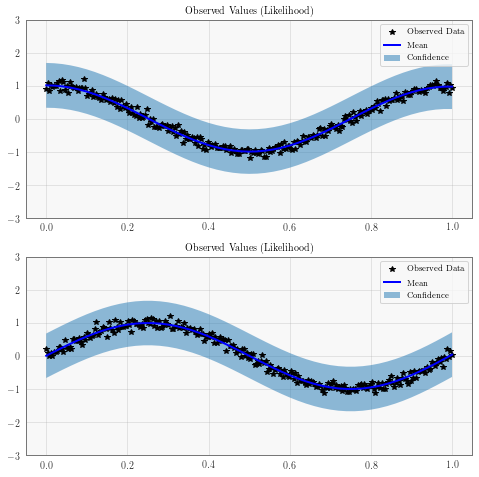

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(2, 1, figsize=(8, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(2, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].squeeze().numpy(), upper[0, :].squeeze().numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'k*')
y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].squeeze().numpy(), upper[1, :].squeeze().numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')